**Firstly grabbing our filtered dataset according to mappings**

In [1]:
# need to grab mean and std for each column so that we can normalize the df and apply clustering
import pyspark.sql.functions as F
import pyspark.sql.types as T

joined = spark.read.parquet('./FINAL_processed_data')

columns = joined.columns
#print(joined.printSchema())

# below is for mean, standard deviation based scaling

stats = joined.select(*[[F.mean(c).alias(c+'_mean') for c in joined.columns] + [F.stddev_pop(c).alias(c+'_stddev') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    if column != 'Season' and column!='record_id':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_mean'])/(stats[column+'_stddev']))

# below is for max, min based scaling
'''stats = joined.select(*[[F.max(c).alias(c+'_max') for c in joined.columns] + [F.min(c).alias(c+'_min') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    if column != 'Season':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_min'])/(stats[column+'_max'] - stats[column+'_min']))'''

print(stats)


print(joined.take(1))

# lets write this data to parquet, just because
#joined.write.parquet('./FINAL_processed_data')


Row(ArrDelay_mean=7.159954113241544, DepDelay_mean=8.155785553305384, ActualElapsedTime_mean=122.11903171401364, Distance_mean=715.1781956065518, origin_lat_mean=37.099659857406145, origin_long_mean=-92.27161607308254, dest_lat_mean=37.09915724198568, dest_long_mean=-92.26712071709692, Season_mean=1.4983448205364176, origin_prcp_mean=25.696228836739326, origin_tmax_mean=205.3709193033514, origin_tmin_mean=94.5765910747429, origin_awnd_mean=38.636158741871185, dest_prcp_mean=25.612486723460716, dest_tmax_mean=205.36587148443542, dest_tmin_mean=94.56188964755093, dest_awnd_mean=38.63819560488218, record_id_mean=327715972788.13043, ArrDelay_stddev=30.939682127010055, DepDelay_stddev=28.437824166810305, ActualElapsedTime_stddev=70.31234179026457, Distance_stddev=569.0274209367315, origin_lat_stddev=5.5991075699082264, origin_long_stddev=16.70378425786922, dest_lat_stddev=5.5997072673137644, dest_long_stddev=16.697214735116198, Season_stddev=1.113054367950728, origin_prcp_stddev=83.85304742

# Running PCR on our BFR clusters for values of k picked based on elbow plots

## For season 0 (Winter) we choose k=7

In [2]:
from pyspark.sql.functions import struct, array
import numpy as np
sample = joined.where(joined.Season == 0).drop('Season').sample(fraction=0.001)
#print(sample.printSchema())
#centers = spark.read.parquet('./New_BFR_Clusters/k=7_season=0')
id_mapping = spark.read.parquet('./New_BFR_Mapping/k=7_season=0').withColumnRenamed('cluster_id','tag')

# tagging records with their cluster_id
sample = sample.join(id_mapping,'record_id').drop('record_id')
print(sample.select('tag').distinct().show())
print(sample.printSchema())


#sample = sample.withColumn("tag", tag_record_wrapped(use_centroids,use_stddevs)(array([sample[col] for col in sample.columns])))
test = sample.toPandas().to_numpy()



+---+
|tag|
+---+
|  0|
|  3|
+---+

None
root
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- origin_prcp: double (nullable = true)
 |-- origin_tmax: double (nullable = true)
 |-- origin_tmin: double (nullable = true)
 |-- origin_awnd: double (nullable = true)
 |-- dest_prcp: double (nullable = true)
 |-- dest_tmax: double (nullable = true)
 |-- dest_tmin: double (nullable = true)
 |-- dest_awnd: double (nullable = true)
 |-- tag: long (nullable = true)

None


In [3]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pca = PCA(2)
pca.fit(test[:,:-1])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.20991724 0.15740018]
[268.17525654 232.21873677]


In [4]:
pd_1 = pd.DataFrame(data = pca.transform(test[:,:-1]), columns=("PCA1","PCA2"))
pd_2 = pd.DataFrame(data = test[:,-1], columns=["tag"])

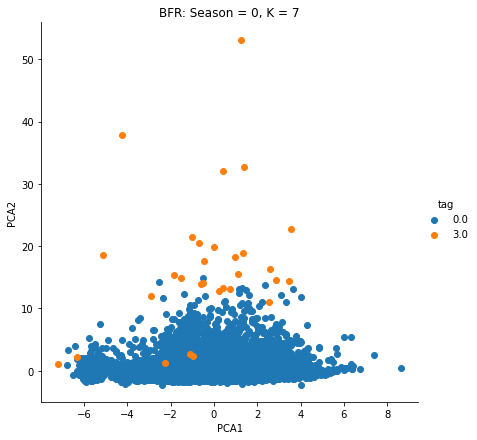

In [5]:
pca_data = pd.concat([pd_1,pd_2], axis=1)
sns.FacetGrid(pca_data,hue="tag", height=6).map(plt.scatter, "PCA1", "PCA2").add_legend()

plt.title("BFR: Season = 0, K = 7")
plt.show()

## For Spring (season =1 ) we choose k=9

In [6]:
from pyspark.sql.functions import struct, array
import numpy as np
sample = joined.where(joined.Season == 1).drop('Season').sample(fraction=0.001)
#print(sample.printSchema())
#centers = spark.read.parquet('./New_BFR_Clusters/k=7_season=0')
id_mapping = spark.read.parquet('./New_BFR_Mapping/k=9_season=1').withColumnRenamed('cluster_id','tag')

# tagging records with their cluster_id
sample = sample.join(id_mapping,'record_id').drop('record_id')
print(sample.printSchema())


#sample = sample.withColumn("tag", tag_record_wrapped(use_centroids,use_stddevs)(array([sample[col] for col in sample.columns])))
test = sample.toPandas().to_numpy()



root
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- origin_prcp: double (nullable = true)
 |-- origin_tmax: double (nullable = true)
 |-- origin_tmin: double (nullable = true)
 |-- origin_awnd: double (nullable = true)
 |-- dest_prcp: double (nullable = true)
 |-- dest_tmax: double (nullable = true)
 |-- dest_tmin: double (nullable = true)
 |-- dest_awnd: double (nullable = true)
 |-- tag: long (nullable = true)

None


In [7]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pca = PCA(2)
pca.fit(test[:,:-1])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.18166721 0.15025196]
[245.11671535 222.9177893 ]


In [8]:
pd_1 = pd.DataFrame(data = pca.transform(test[:,:-1]), columns=("PCA1","PCA2"))
pd_2 = pd.DataFrame(data = test[:,-1], columns=["tag"])

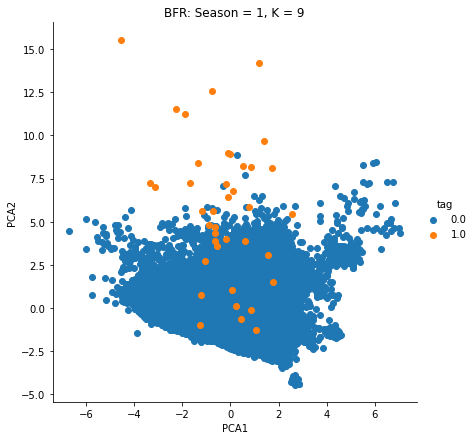

In [9]:
pca_data = pd.concat([pd_1,pd_2], axis=1)
sns.FacetGrid(pca_data,hue="tag", height=6).map(plt.scatter, "PCA1", "PCA2").add_legend()

plt.title("BFR: Season = 1, K = 9")
plt.show()

## For season=2, Summer, we choose k=7

In [10]:
from pyspark.sql.functions import struct, array
import numpy as np
sample = joined.where(joined.Season == 2).drop('Season').sample(fraction=0.001)
#print(sample.printSchema())
#centers = spark.read.parquet('./New_BFR_Clusters/k=7_season=0')
id_mapping = spark.read.parquet('./New_BFR_Mapping/k=7_season=2').withColumnRenamed('cluster_id','tag')

# tagging records with their cluster_id
sample = sample.join(id_mapping,'record_id').drop('record_id')
print(sample.printSchema())


#sample = sample.withColumn("tag", tag_record_wrapped(use_centroids,use_stddevs)(array([sample[col] for col in sample.columns])))
test = sample.toPandas().to_numpy()



root
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- origin_prcp: double (nullable = true)
 |-- origin_tmax: double (nullable = true)
 |-- origin_tmin: double (nullable = true)
 |-- origin_awnd: double (nullable = true)
 |-- dest_prcp: double (nullable = true)
 |-- dest_tmax: double (nullable = true)
 |-- dest_tmin: double (nullable = true)
 |-- dest_awnd: double (nullable = true)
 |-- tag: long (nullable = true)

None


In [11]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pca = PCA(2)
pca.fit(test[:,:-1])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.18791711 0.17160336]
[240.72613218 230.03979037]


In [12]:
pd_1 = pd.DataFrame(data = pca.transform(test[:,:-1]), columns=("PCA1","PCA2"))
pd_2 = pd.DataFrame(data = test[:,-1], columns=["tag"])

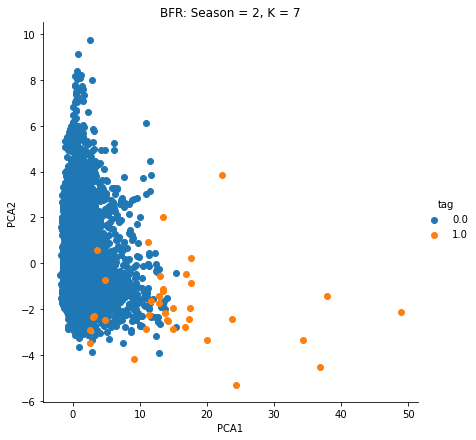

In [13]:
pca_data = pd.concat([pd_1,pd_2], axis=1)
sns.FacetGrid(pca_data,hue="tag", height=6).map(plt.scatter, "PCA1", "PCA2").add_legend()

plt.title("BFR: Season = 2, K = 7")
plt.show()

## For season=3, Fall, we choose k=8

In [14]:
from pyspark.sql.functions import struct, array
import numpy as np
sample = joined.where(joined.Season == 3).drop('Season').sample(fraction=0.001)
#print(sample.printSchema())
#centers = spark.read.parquet('./New_BFR_Clusters/k=7_season=0')
id_mapping = spark.read.parquet('./New_BFR_Mapping/k=8_season=3').withColumnRenamed('cluster_id','tag')

# tagging records with their cluster_id
sample = sample.join(id_mapping,'record_id').drop('record_id')
print(sample.printSchema())


#sample = sample.withColumn("tag", tag_record_wrapped(use_centroids,use_stddevs)(array([sample[col] for col in sample.columns])))
test = sample.toPandas().to_numpy()



root
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- origin_prcp: double (nullable = true)
 |-- origin_tmax: double (nullable = true)
 |-- origin_tmin: double (nullable = true)
 |-- origin_awnd: double (nullable = true)
 |-- dest_prcp: double (nullable = true)
 |-- dest_tmax: double (nullable = true)
 |-- dest_tmin: double (nullable = true)
 |-- dest_awnd: double (nullable = true)
 |-- tag: long (nullable = true)

None


In [15]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pca = PCA(2)
pca.fit(test[:,:-1])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.18449102 0.15108711]
[241.13119562 218.21243165]


In [16]:
pd_1 = pd.DataFrame(data = pca.transform(test[:,:-1]), columns=("PCA1","PCA2"))
pd_2 = pd.DataFrame(data = test[:,-1], columns=["tag"])

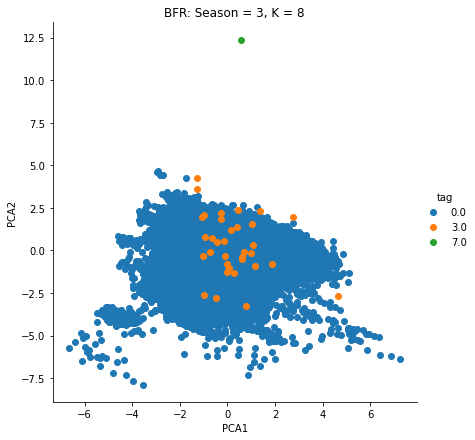

In [17]:
pca_data = pd.concat([pd_1,pd_2], axis=1)
sns.FacetGrid(pca_data,hue="tag", height=6).map(plt.scatter, "PCA1", "PCA2").add_legend()

plt.title("BFR: Season = 3, K = 8")
plt.show()

## For season=Everything, which is all data, we choose k=8

In [18]:
from pyspark.sql.functions import struct, array
import numpy as np
sample = joined.drop('Season').sample(fraction=0.001)
#print(sample.printSchema())
#centers = spark.read.parquet('./New_BFR_Clusters/k=7_season=0')
id_mapping = spark.read.parquet('./New_BFR_Mapping/k=8_season=EVERYTHING').withColumnRenamed('cluster_id','tag')

# tagging records with their cluster_id
sample = sample.join(id_mapping,'record_id').drop('record_id')
print(sample.printSchema())


#sample = sample.withColumn("tag", tag_record_wrapped(use_centroids,use_stddevs)(array([sample[col] for col in sample.columns])))
test = sample.toPandas().to_numpy()



root
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- origin_prcp: double (nullable = true)
 |-- origin_tmax: double (nullable = true)
 |-- origin_tmin: double (nullable = true)
 |-- origin_awnd: double (nullable = true)
 |-- dest_prcp: double (nullable = true)
 |-- dest_tmax: double (nullable = true)
 |-- dest_tmin: double (nullable = true)
 |-- dest_awnd: double (nullable = true)
 |-- tag: long (nullable = true)

None


In [19]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pca = PCA(2)
pca.fit(test[:,:-1])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.23267261 0.13782402]
[582.52644896 448.33791395]


In [20]:
pd_1 = pd.DataFrame(data = pca.transform(test[:,:-1]), columns=("PCA1","PCA2"))
pd_2 = pd.DataFrame(data = test[:,-1], columns=["tag"])

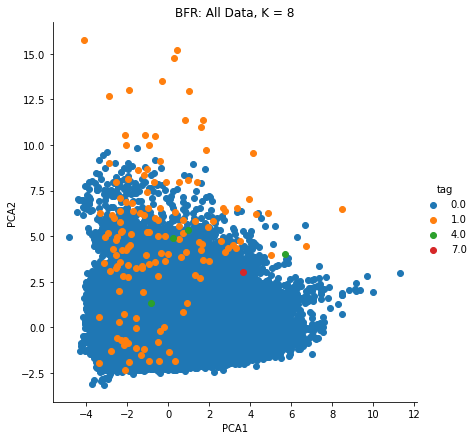

In [21]:
pca_data = pd.concat([pd_1,pd_2], axis=1)
sns.FacetGrid(pca_data,hue="tag", height=6).map(plt.scatter, "PCA1", "PCA2").add_legend()

plt.title("BFR: All Data, K = 8")
plt.show()